In [39]:
import io
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
import pylab as pl
import os
import shapely
from fiona.crs import from_epsg
from geopandas import GeoDataFrame
import geopandas as gpd
from sklearn.cluster import KMeans
from shapely.geometry import Point
from sklearn.mixture import GMM


from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

%matplotlib inline

In [2]:
# !wget 'https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip'

In [3]:
#these commands can be run on the shell and get the data with the command wget

# !for ((y=94; y<=99; y+=1)); do wget \
# https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp$y\totals.zip; done

# !for ((y=0; y<=1; y+=1)); do wget \
# https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp0$y\totals.zip; done

# !for ((y=2; y<=9; y+=1)); do wget \
# https://www2.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

# !for ((y=10; y<=14; y+=1)); do wget \
# https://www2.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done

___

In [4]:
# shapefile
# !unzip "application%2Fzip"

In [5]:
# unzipping census files
# !unzip zbp14totals.zip

# 1. Data cleaning

# ADD IN HOW YOU UNZIPPED THE DATA

In [6]:
df = pd.read_csv('zbp14totals.txt')
df.head()

,zip,name,empflag,emp_nf,emp,qp1_nf,qp1,ap_nf,ap,est,city,stabbr,cty_name
0,501,"HOLTSVILLE, NY",B,D,0,D,0,D,0,4,HOLTSVILLE,NY,SUFFOLK
1,1001,"AGAWAM, MA",NaN,G,9110,G,88574,G,364418,458,AGAWAM,MA,HAMPDEN
2,1002,"AMHERST, MA",NaN,H,17513,G,99432,G,421772,560,AMHERST,MA,HAMPSHIRE
3,1003,"AMHERST, MA",NaN,G,227,H,1911,H,8026,18,AMHERST,MA,HAMPSHIRE
4,1004,"AMHERST, MA",C,S,0,S,0,H,4921,13,AMHERST,MA,HAMPSHIRE


In [7]:
# pulling in data in order, with just the columns we need

years_l1 = ['zbp94totals.txt','zbp95totals.txt','zbp96totals.txt', 'zbp97totals.txt']
years_u = ['zbp98totals.txt', 'zbp99totals.txt','zbp00totals.txt', 'zbp01totals.txt', 
           'zbp02totals.txt',]
years_l2 = ['zbp03totals.txt','zbp04totals.txt','zbp05totals.txt','zbp06totals.txt',
            'zbp07totals.txt','zbp08totals.txt','zbp09totals.txt','zbp10totals.txt',
            'zbp11totals.txt','zbp12totals.txt','zbp13totals.txt','zbp14totals.txt']

count = 1994
count2 = 1998
count3 = 2003

df_list = []

for i in years_l1:
    df = pd.read_csv(i)
    df = df[['zip', 'est']]
    df = df.rename(columns={'zip': 'ZIP', 'est': count})
    df_list.append(df)
    count +=1
    
for i in years_u:
    df = pd.read_csv(i)
    df = df[['ZIP', 'EST']]
    df = df.rename(columns={'EST': count2})
    df_list.append(df)
    count2 +=1 
    
for i in years_l2:
    df = pd.read_csv(i)
    df = df[['zip', 'est']]
    df = df.rename(columns={'zip': 'ZIP', 'est': count3})
    df_list.append(df)
    count3 +=1    

In [8]:
# import shapefile
nyczip = gpd.read_file('ZIP_CODE_040114.shp')

# redefine with useful columns
nyczip = nyczip[['ZIPCODE', 'geometry']]

# rename for easy merging
nyczip = nyczip.rename(columns={'ZIPCODE': 'ZIP'})
nyczip['ZIP'] = nyczip['ZIP'].astype(int)
nyczip.head()

,ZIP,geometry
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [9]:
# MERGE

# this ensures we're not overriding "data" each time
data = pd.merge(nyczip, df_list[0], on='ZIP')

# for all years, merge on ZIP, merge with shape
for i in range(1,21):
    data = pd.merge(data, df_list[i], on='ZIP')

data.head()               

,ZIP,geometry,1994,1995,1996,1997,1998,1999,2000,2001,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",51,50,53,51,51,58,65,57,...,82,80,84,90,92,98,101,95,99,109
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",406,420,433,456,476,473,477,493,...,556,565,556,592,621,675,674,726,755,772
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",505,494,502,527,519,541,520,527,...,587,570,587,602,647,699,713,721,731,752
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",381,387,388,410,416,409,417,422,...,491,499,514,520,543,580,597,623,673,696
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",985,1015,1049,1075,1118,1149,1161,1180,...,1332,1331,1377,1397,1457,1474,1523,1605,1687,1736


In [10]:
# work with years only while we normalize
tseries = pd.DataFrame(data)
tseries = tseries.drop(['geometry', 'ZIP'], axis=1)

# add columns for mean and std for normalizing
tseries['mean'] = tseries.mean(axis=1)
tseries['std'] = tseries.std(axis=1)

In [11]:
# NORMALIZE 
# Subtract mean: subtracting mean along rows
tseries_subtract = tseries.sub(tseries.mean(axis=1), axis=0)

# Divide by std: divide by std along rows
tseries_divide = tseries_subtract.divide(tseries.std(axis=1), axis=0)

# annnnnd... normalized data!
data_norm = tseries_divide

In [48]:
data_norm.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2009,2010,2011,2012,2013,2014,mean,std,cluster_labels,gmm_cluster_labels
0,-1.031433,-1.076678,-0.940943,-1.031433,-1.031433,-0.714720,-0.398006,-0.759964,0.190176,0.009197,...,0.823603,1.095071,1.230805,0.959337,1.140316,1.592764,0.112613,-2.477494,0,2
1,-0.969335,-0.869992,-0.777745,-0.614539,-0.472620,-0.493908,-0.465524,-0.351989,0.024095,0.187301,...,0.556290,0.939470,0.932374,1.301363,1.507145,1.627775,0.140671,-3.094761,0,2
2,-0.505395,-0.587950,-0.527910,-0.340285,-0.400325,-0.235214,-0.392820,-0.340285,0.034966,0.064986,...,0.560317,0.950577,1.055647,1.115687,1.190737,1.348342,0.167554,-3.686197,2,1
3,-0.793585,-0.744923,-0.736812,-0.558385,-0.509723,-0.566495,-0.501612,-0.461060,0.001229,0.074222,...,0.520291,0.820374,0.958250,1.169119,1.574636,1.761174,0.142581,-3.136779,0,2
4,-0.886493,-0.789153,-0.678836,-0.594475,-0.454955,-0.354371,-0.315435,-0.253787,-0.098044,-0.036396,...,0.644979,0.700138,0.859126,1.125187,1.391248,1.550235,0.154266,-3.393844,0,2


# 2. Cluster the NUMBER OF ESTABLISHMENTS time series with K-means in  clusters 

In [12]:
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans

def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

For n_clusters = 2 The average silhouette_score is : 0.479651581466
For n_clusters = 3 The average silhouette_score is : 0.314254247818
For n_clusters = 4 The average silhouette_score is : 0.216333474416
For n_clusters = 5 The average silhouette_score is : 0.222115483995
For n_clusters = 6 The average silhouette_score is : 0.230050572924


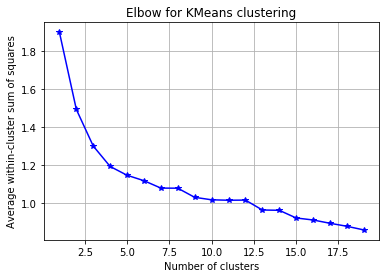

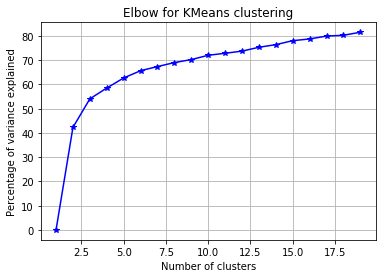

In [13]:
X=np.asarray(data_norm.iloc[:,:-1])
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:

    clusterer = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

#elbow
elbow(X,range(1,20))

In [72]:
cluster_km = KMeans(n_clusters = 5, random_state=100)
cluster_labels_km = cluster_km.fit_predict(data_norm)
data_norm['cluster_labels_km'] = cluster_labels_km

In [73]:
# setting for second algo
cluster_gm = GMM(n_components = 5, random_state = 100)
cluster_labels_gm = cluster_gm.fit_predict(data_norm)
data_norm['cluster_labels_gm'] = cluster_labels_gm



In [74]:
#merging back in zip and geometry 
data = pd.concat([nyczip, data_norm], axis=1)
data.head()

,ZIP,geometry,1994,1995,1996,1997,1998,1999,2000,2001,...,2011,2012,2013,2014,mean,std,cluster_labels,gmm_cluster_labels,cluster_labels_gm,cluster_labels_km
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",-1.031433,-1.076678,-0.940943,-1.031433,-1.031433,-0.714720,-0.398006,-0.759964,...,1.230805,0.959337,1.140316,1.592764,0.112613,-2.477494,2.0,3.0,2.0,0.0
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",-0.969335,-0.869992,-0.777745,-0.614539,-0.472620,-0.493908,-0.465524,-0.351989,...,0.932374,1.301363,1.507145,1.627775,0.140671,-3.094761,2.0,3.0,2.0,0.0
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",-0.505395,-0.587950,-0.527910,-0.340285,-0.400325,-0.235214,-0.392820,-0.340285,...,1.055647,1.115687,1.190737,1.348342,0.167554,-3.686197,1.0,0.0,0.0,2.0
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",-0.793585,-0.744923,-0.736812,-0.558385,-0.509723,-0.566495,-0.501612,-0.461060,...,0.958250,1.169119,1.574636,1.761174,0.142581,-3.136779,2.0,3.0,2.0,0.0
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",-0.886493,-0.789153,-0.678836,-0.594475,-0.454955,-0.354371,-0.315435,-0.253787,...,0.859126,1.125187,1.391248,1.550235,0.154266,-3.393844,2.0,3.0,2.0,0.0


In [16]:
type(data)

geopandas.geodataframe.GeoDataFrame

# 3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).

In [17]:
data.head()

,ZIP,geometry,1994,1995,1996,1997,1998,1999,2000,2001,...,2008,2009,2010,2011,2012,2013,2014,mean,std,cluster_labels
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",-1.031433,-1.076678,-0.940943,-1.031433,-1.031433,-0.714720,-0.398006,-0.759964,...,0.733113,0.823603,1.095071,1.230805,0.959337,1.140316,1.592764,0.112613,-2.477494,0.0
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",-0.969335,-0.869992,-0.777745,-0.614539,-0.472620,-0.493908,-0.465524,-0.351989,...,0.350508,0.556290,0.939470,0.932374,1.301363,1.507145,1.627775,0.140671,-3.094761,0.0
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",-0.505395,-0.587950,-0.527910,-0.340285,-0.400325,-0.235214,-0.392820,-0.340285,...,0.222591,0.560317,0.950577,1.055647,1.115687,1.190737,1.348342,0.167554,-3.686197,2.0
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",-0.793585,-0.744923,-0.736812,-0.558385,-0.509723,-0.566495,-0.501612,-0.461060,...,0.333753,0.520291,0.820374,0.958250,1.169119,1.574636,1.761174,0.142581,-3.136779,0.0
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",-0.886493,-0.789153,-0.678836,-0.594475,-0.454955,-0.354371,-0.315435,-0.253787,...,0.450301,0.644979,0.700138,0.859126,1.125187,1.391248,1.550235,0.154266,-3.393844,0.0


In [18]:
cluster_time = data.groupby('cluster_labels').mean()
cluster_time

,ZIP,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2007,2008,2009,2010,2011,2012,2013,2014,mean,std
cluster_labels,,,,,,,,,,,,,,,,,,,,,
0.0,10625.931034,-0.917358,-0.865972,-0.796241,-0.727376,-0.661957,-0.539724,-0.432188,-0.337354,-0.104661,...,0.467681,0.575769,0.724584,0.872898,1.008442,1.110603,1.237906,1.396858,0.130939,-2.880667
1.0,10282.764706,0.255525,0.396698,0.452871,0.615284,0.605951,0.666477,0.811848,0.734056,0.507875,...,-0.100486,-0.223970,-0.362888,-0.539699,-0.722849,-0.799073,-0.755524,-0.796207,0.126104,-2.774282
2.0,10856.602041,-0.540197,-0.468031,-0.389696,-0.307380,-0.272573,-0.227098,-0.160910,-0.118579,0.051509,...,0.383972,0.420287,0.481086,0.583843,0.667349,0.786612,0.913313,1.027917,0.180024,-3.960539
3.0,10480.950820,0.104298,0.081949,0.059410,0.085326,0.125745,0.166049,0.208614,0.191876,0.164920,...,0.222463,0.209614,0.184983,0.215684,0.204635,0.302421,0.362418,0.435601,0.195691,-4.305193
4.0,10172.222222,1.408613,1.435123,1.224277,1.053155,1.025691,0.934159,0.783084,0.162260,-0.496880,...,-0.506368,-0.499873,-0.387443,-0.384497,-0.387281,-0.386397,-0.456584,-0.397819,0.082736,-1.820192


Text(0,0.5,'cluster')

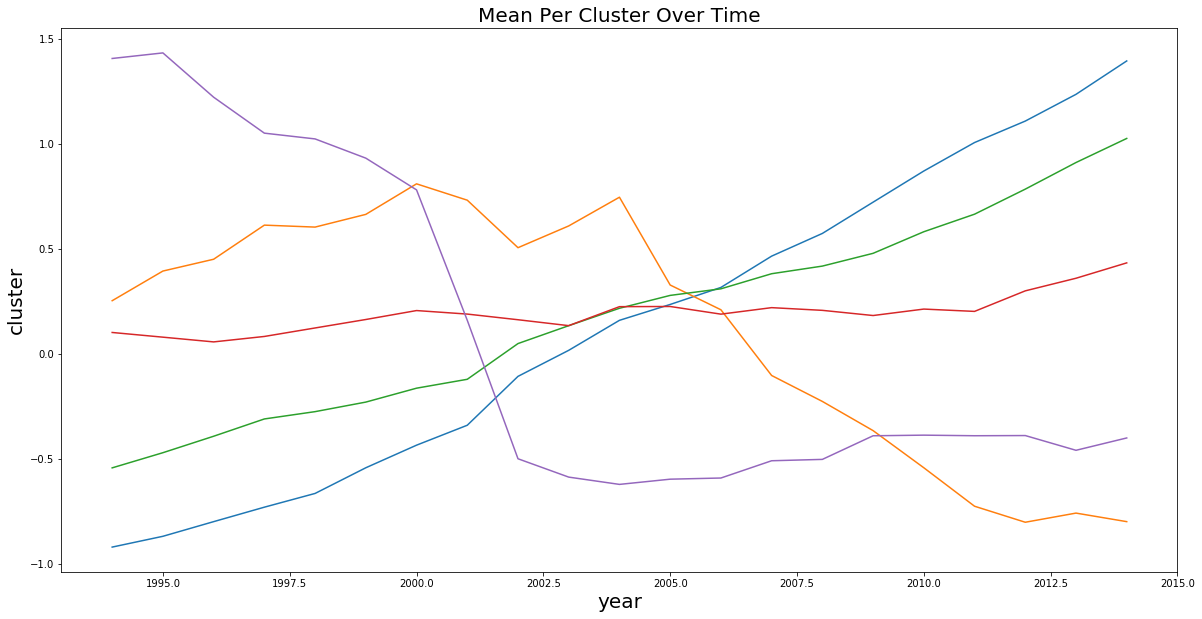

In [79]:
plt.figure(figsize=(20,10))
plt.plot(cluster_time.ix[:,1:-2].T)
plt.title('Mean Per Cluster Over Time', fontsize=20)
plt.xlabel('year', fontsize=20)
plt.ylabel('cluster', fontsize=20)


# 5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters

In [75]:
# changing back to geodataframe
crs = {'init': 'epsg:4326'}
gdf_data = GeoDataFrame(data, crs=crs, geometry='geometry')
gdf_data.head()

# gdf_data.shape

,ZIP,geometry,1994,1995,1996,1997,1998,1999,2000,2001,...,2011,2012,2013,2014,mean,std,cluster_labels,gmm_cluster_labels,cluster_labels_gm,cluster_labels_km
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",-1.031433,-1.076678,-0.940943,-1.031433,-1.031433,-0.714720,-0.398006,-0.759964,...,1.230805,0.959337,1.140316,1.592764,0.112613,-2.477494,2.0,3.0,2.0,0.0
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",-0.969335,-0.869992,-0.777745,-0.614539,-0.472620,-0.493908,-0.465524,-0.351989,...,0.932374,1.301363,1.507145,1.627775,0.140671,-3.094761,2.0,3.0,2.0,0.0
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",-0.505395,-0.587950,-0.527910,-0.340285,-0.400325,-0.235214,-0.392820,-0.340285,...,1.055647,1.115687,1.190737,1.348342,0.167554,-3.686197,1.0,0.0,0.0,2.0
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",-0.793585,-0.744923,-0.736812,-0.558385,-0.509723,-0.566495,-0.501612,-0.461060,...,0.958250,1.169119,1.574636,1.761174,0.142581,-3.136779,2.0,3.0,2.0,0.0
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",-0.886493,-0.789153,-0.678836,-0.594475,-0.454955,-0.354371,-0.315435,-0.253787,...,0.859126,1.125187,1.391248,1.550235,0.154266,-3.393844,2.0,3.0,2.0,0.0


Text(0.5,1,'kmeans clusters')

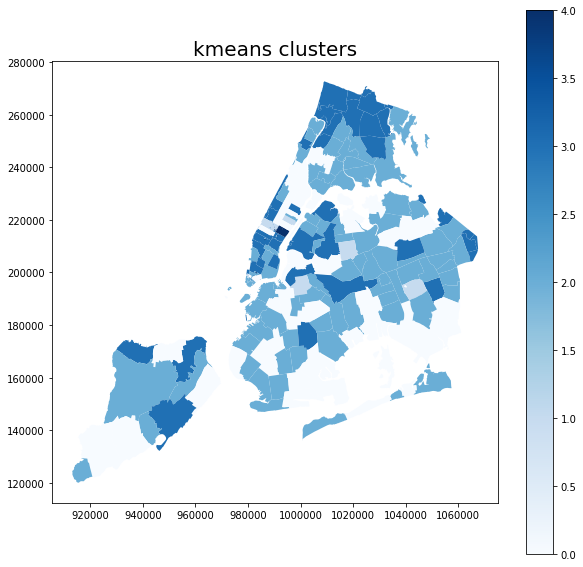

In [77]:
# plotting
gdf_data.plot(column='cluster_labels_km', cmap='Blues', figsize=(10,10), legend = True)
plt.title('kmeans clusters', fontsize=20)

# 6. Guassian Mixture

Text(0.5,1,'gaussian mixture clusters')

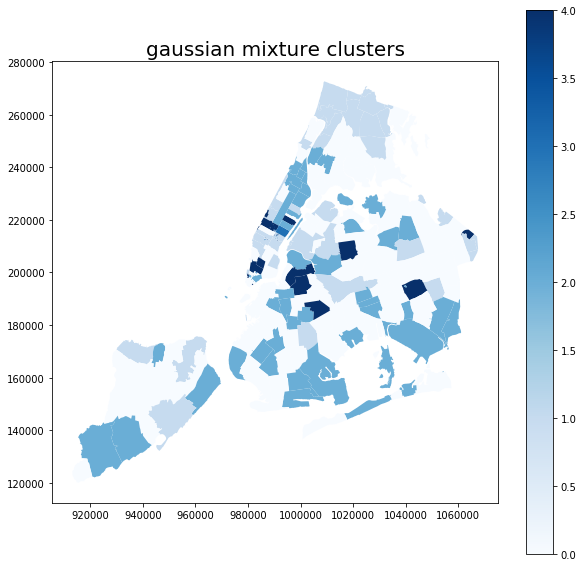

In [78]:
# plotting
gdf_data.plot(column='cluster_labels_gm', cmap='Blues', figsize=(10,10), legend = True)
plt.title('gaussian mixture clusters', fontsize=20)

# 7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 